<a href="https://colab.research.google.com/github/ikechukwuhenry/DeepLearningNotebooks/blob/main/cifar_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"x_train: {x_train.shape} - y_train: {y_train.shape}")
print(f"x_test: {x_test.shape} - y_test: {y_test.shape}")
input_shape = x_train.shape[1:]

170508288/170498071 [==============================] - 2s 0us/step
x_train: (50000, 32, 32, 3) - y_train: (50000, 1)
x_test: (10000, 32, 32, 3) - y_test: (10000, 1)


In [3]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(72, 72),
        layers.RandomFlip("horizontal"),
        # layers.RandomFlip('horizontal',input_shape=(input_shape[0], input_shape[1],3)),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2,projection_dim,] 
transformer_layers = 8
mlp_head_units = [2048, 1024]
num_classes = 10


(-0.5, 31.5, 31.5, -0.5)

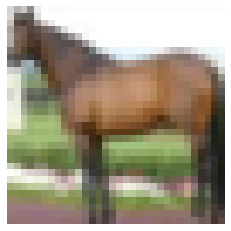

In [5]:

import matplotlib.pyplot as plt
 
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
 
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
# patches = Patches(patch_size)

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
 
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
 
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
 
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

In [13]:
model = create_vit_classifier()
# optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [14]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [15]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
       keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
       keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"), ],)

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,)

Epoch 1/100
176/176 [==============================] - 168s 838ms/step - loss: 2.0519 - accuracy: 0.3101 - top-5-accuracy: 0.8068 - val_loss: 1.4929 - val_accuracy: 0.4548 - val_top-5-accuracy: 0.9134
Epoch 2/100
176/176 [==============================] - 146s 831ms/step - loss: 1.5619 - accuracy: 0.4373 - top-5-accuracy: 0.8990 - val_loss: 1.2895 - val_accuracy: 0.5380 - val_top-5-accuracy: 0.9444
Epoch 3/100
176/176 [==============================] - 146s 831ms/step - loss: 1.3980 - accuracy: 0.4966 - top-5-accuracy: 0.9267 - val_loss: 1.1914 - val_accuracy: 0.5694 - val_top-5-accuracy: 0.9610
Epoch 4/100
176/176 [==============================] - 146s 831ms/step - loss: 1.2979 - accuracy: 0.5415 - top-5-accuracy: 0.9373 - val_loss: 1.0870 - val_accuracy: 0.6174 - val_top-5-accuracy: 0.9632
Epoch 5/100
176/176 [==============================] - 146s 831ms/step - loss: 1.2245 - accuracy: 0.5669 - top-5-accuracy: 0.9450 - val_loss: 1.0025 - val_accuracy: 0.6458 - val_top-5-accuracy: 0.

In [17]:
!pip install pyyaml h5py 

In [18]:
# assign location
path='./cifar_transformer/Weights_folder/Weights'

In [19]:
model.save(path)

INFO:tensorflow:Assets written to: ./cifar_transformer/Weights_folder/Weights/assets


INFO:tensorflow:Assets written to: ./cifar_transformer/Weights_folder/Weights/assets


In [22]:
model.save_weights('./cifar_transformer/h5/my_model.h5') 

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']                
                                                                                              

In [25]:
from tensorflow import keras
loaded_model = keras.models.load_model(path) 

In [26]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches[0][0]']                
                                                                                              